データをロードする
モデルを構成する
CKAを計算する

In [47]:
import torch
from torch.utils.data import DataLoader
# from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18
from tqdm.autonotebook import tqdm
from copy import deepcopy
import torch.nn as nn

# added by me
import sys
import json
import os
sys.path.append(os.path.abspath("../.."))
from models import model_dict
from dataset.cifar10 import get_cifar10_dataloaders
from dataset.cinic10 import get_cinic10_dataloaders

## Setup DataLoader and Models 

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [ ]:
root = "../"

model_path = [
    os.path.join(root, "save/teachers/models/resnet32x4_vanilla_cifar10_trial_0_epochs_240_bs_64/resnet32x4_best.pth"),
    os.path.join(root, "save/teachers/models/resnet8x4_vanilla_cifar10_trial_0_epochs_240_bs_64/resnet8x4_best.pth"),
    os.path.join(root, "save/students/models/S~resnet8x4_T~resnet32x4_cifar10_kd_r~1.0_a~1.0_b~400.0_0/resnet8x4_best.pth"),
    os.path.join(root, "save/students/models/S~resnet8x4_T~resnet32x4_cifar10_semckd_r~1.0_a~1.0_b~400.0_0/resnet8x4_best.pth"),
    os.path.join(root, "save/teachers/models/vgg8_vanilla_cifar10_trial_0_epochs_240_bs_64/vgg8_best.pth"),
    os.path.join(root, "save/teachers/models/vgg13_vanilla_cifar10_trial_0_epochs_240_bs_64/vgg13_best.pth"),
    os.path.join(root, "save/teachers/models/resnet32x4_vanilla_cinic10_trial_0_epochs_240_bs_64/resnet32x4_best.pth"),
    os.path.join(root, "save/teachers/models/resnet8x4_vanilla_cinic10_trial_0_epochs_240_bs_64/resnet8x4_best.pth"),
    os.path.join(root, "save/students/models/S~resnet8x4_T~resnet32x4_cinic10_kd_r~1.0_a~1.0_b~400.0_0/resnet8x4_best.pth"),
    os.path.join(root, "save/teachers/models/vgg8_vanilla_cinic10_trial_0_epochs_240_bs_64/vgg8_best.pth"),
    os.path.join(root, "save/teachers/models/vgg13_vanilla_cinic10_trial_0_epochs_240_bs_64/vgg13_best.pth"),
]

model_names = {
    # CIFAR-10 models
    model_path[0]: "resnet32x4",
    model_path[1]: "resnet8x4",
    model_path[2]: "resnet8x4_kd",
    model_path[3]: "resnet8x4_semckd",
    model_path[4]: "vgg8",
    model_path[5]: "vgg13",
    # CINIC-10 models
    model_path[6]: "resnet32x4",
    model_path[7]: "resnet8x4",
    model_path[8]: "resnet8x4_kd",
    model_path[9]: "vgg8",
    model_path[10]: "vgg13",
}

dataset_cka = {"cifar10": get_cifar10_dataloaders, "cinic10": get_cinic10_dataloaders}


CINIC-10 DataLoader


In [ ]:
# options
root = "../.."
class Opt:
    path_t = model_path[10]
    path_s = model_path[10]
    gpu = 0

opt = Opt()

_, dataloader = dataset_cka["cinic10"](batch_size=64, num_workers=4, data_folder_dir="../../data/cinic-10") # only test set

In [52]:
def get_params_from_json(json_path, item):
    with open(json_path, "r") as f:
        params = json.load(f)
    if isinstance(item, list):
        for key in item:
            if key in params:
                return params[key]
        raise KeyError(f"None of the keys {item} found in {json_path}")
    else:
        return params[item]

In [53]:
def load_model(model_path, device="cpu"):
    parent_dir = os.path.dirname(model_path)
    parameter_json_path = os.path.join(parent_dir, "parameters.json")

    model_name = get_params_from_json(parameter_json_path, ["model", "model_s"])
    model_dataset = get_params_from_json(parameter_json_path, ["dataset"])
    n_cls = {
        'cifar10':10,
        'cifar100': 100,
        'imagenet': 1000,
        'cinic10': 10,
    }.get(model_dataset, None)
    model = model_dict[model_name](num_classes=n_cls)

    state_dict = torch.load(model_path, map_location=device)
    if "model" in state_dict:
        state_dict = state_dict["model"]
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

In [54]:
# model1 = resnet18(pretrained=True).cuda()
# model1.eval()
# model2 = deepcopy(model1)
# model2.eval()
# print('Dummy models created')

# GPUを使う場合
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 画像がgpuにある場合はcudaを使う
model_t = load_model(opt.path_t, device=device)
model_s = load_model(opt.path_s, device=device)

In [55]:
for x, y in dataloader:
    print(x.shape)  # 例: torch.Size([256, 3, 32, 32])
    break

torch.Size([32, 3, 32, 32])


## Compute CKA 

In [56]:
from cka import CKACalculator

### Basic Usage 

Initializing the `CKACalculator` object will add forward hooks to both `model1` and `model2`. 
The default modules that are hooked are: `Bottleneck`, `BasicBlock`, `Conv2d`, `AdaptiveAvgPool2d`, `MaxPool2d`, and all instances of `BatchNorm`. 
Note that `Bottleneck` and `BasicBlock` are from the `torchvision` implementation, and will not add hooks to any custom implementations of `Bottleneck/BasicBlock`.

For ResNet18, a total of 50 hooks are added.

By default, the intermediate features are flattened with `flatten_hook_fn` and 10 epochs are run.

In [57]:
layers = (nn.Conv2d,nn.Linear)
calculator = CKACalculator(model1=model_t, model2=model_s, dataloader=dataloader, num_epochs=10, hook_layer_types=layers)

No hook function provided. Using flatten_hook_fn.
11 Hooks registered. Total hooks: 11
No hook function provided. Using flatten_hook_fn.
11 Hooks registered. Total hooks: 11


Now we can calculate the CKA matrix 

In [58]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 0:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/2813 [00:00<?, ?it/s]

CKA output size: torch.Size([11, 11])


In [59]:
print("type:", type(cka_output))
print("shape:", getattr(cka_output, "shape", None))
print("size:", getattr(cka_output, "size", None))
print("device:", getattr(cka_output, "device", None))
print("min:", cka_output.min().item() if hasattr(cka_output, "min") else None)
print("max:", cka_output.max().item() if hasattr(cka_output, "max") else None)
print("sample values:", cka_output.flatten()[:10])

type: <class 'torch.Tensor'>
shape: torch.Size([11, 11])
size: <built-in method size of Tensor object at 0x7576bba4b060>
device: cuda:0
min: 0.03518906980752945
max: 1.0000030994415283
sample values: tensor([1.0000, 0.8095, 0.3803, 0.3708, 0.2788, 0.2631, 0.2015, 0.0858, 0.0441,
        0.0396], device='cuda:0')


In [60]:
# print(cka_output)
# # 保存
# torch.save(cka_output.cpu(), "cka_output.pt")
# import numpy as np
# np.save("cka_output.npy", cka_output.cpu().numpy())


In [61]:

# 読み込み
# cka_output = torch.load("cka_output.pt")
# # 読み込み
# cka_output = torch.from_numpy(np.load("cka_output.npy"))

#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

In [62]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 3)

Text(0, 0.5, 'vgg13 Layers')

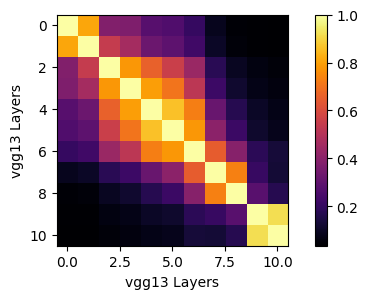

In [63]:
plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.xlabel(model_names[opt.path_t] + ' Layers')
plt.ylabel(model_names[opt.path_s] + ' Layers')
# plt.title('CKA Matrix')

In [64]:
for i, name in enumerate(calculator.module_names_X):
    print(f"Layer {i}: \t{name}")

Layer 0: 	block0.0
Layer 1: 	block0.3
Layer 2: 	block1.0
Layer 3: 	block1.3
Layer 4: 	block2.0
Layer 5: 	block2.3
Layer 6: 	block3.0
Layer 7: 	block3.3
Layer 8: 	block4.0
Layer 9: 	block4.3
Layer 10: 	classifier


In [65]:
# ここまで実行したい
raise SystemExit  # ここでノートブックの実行が停止します

SystemExit: 

### Advanced Usage 

We can customize other parameters of the `CKACalculator`. 
Most importantly, we can select which modules to hook. 

Before instantiating a new instance of `CKACalculator` on, make sure to first call the `reset` method. 
This clears all hooks registered in the models.

In [ ]:
# Reset calculator to clear hooks
calculator.reset()
torch.cuda.empty_cache()

21 handles removed.
21 handles removed.


In [ ]:
import torch.nn as nn

Let's consider outputs of `Conv2d` and `BatchNorm2d` only. This will create 40 hooks.

For custom layers, add the custom modules in the same manner as shown below.

In [ ]:
layers = (nn.Conv2d, nn.BatchNorm2d)

In [ ]:
calculator = CKACalculator(model1=model_t, model2=model_s, dataloader=dataloader, hook_layer_types=layers)

No hook function provided. Using flatten_hook_fn.
20 Hooks registered. Total hooks: 20
No hook function provided. Using flatten_hook_fn.
20 Hooks registered. Total hooks: 20


In [ ]:
cka_output = calculator.calculate_cka_matrix()

Epoch 9: 100%|██████████| 313/313 [00:09<00:00, 34.11it/s] 


#### Visualize output 

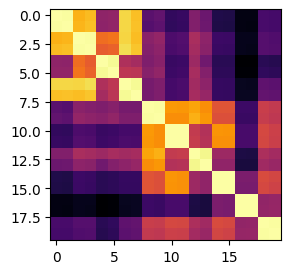

In [ ]:
plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.xlabel('Teacher Model Layers')
plt.ylabel('Student Model Layers')

#### Extract module names 

In [ ]:
for i, name in enumerate(calculator.module_names_X):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	bn1
Layer 2: 	layer1.0.conv1
Layer 3: 	layer1.0.bn1
Layer 4: 	layer1.0.conv2
Layer 5: 	layer1.0.bn2
Layer 6: 	layer1.0.downsample.0
Layer 7: 	layer1.0.downsample.1
Layer 8: 	layer2.0.conv1
Layer 9: 	layer2.0.bn1
Layer 10: 	layer2.0.conv2
Layer 11: 	layer2.0.bn2
Layer 12: 	layer2.0.downsample.0
Layer 13: 	layer2.0.downsample.1
Layer 14: 	layer3.0.conv1
Layer 15: 	layer3.0.bn1
Layer 16: 	layer3.0.conv2
Layer 17: 	layer3.0.bn2
Layer 18: 	layer3.0.downsample.0
Layer 19: 	layer3.0.downsample.1
